## Week 3B: Geospatial Data Analysis and GeoPandas

- Section 401
- Sep 20, 2023

## Housekeeping

- [Homework #1](https://github.com/MUSA-550-Fall-2023/assignment-1) due on Monday, (9/25)
- [Homework #2](https://github.com/MUSA-550-Fall-2023/assignment-2) assigned on Monday, due in two weeks
- Choose a dataset to visualize and explore
    - [OpenDataPhilly](https://opendataphilly.org) or one your choosing
    - Email me if you want to analyze one that's not on OpenDataPhilly

## Agenda for Week #3

**Last lecture**
- Vector data and introduction to GeoPandas
- Spatial relationships

**Today**
- Spatial joins
- Visualization for geospatial data
- Demo: 311 requests by neighborhood in Philadelphia
- Exercise: Property assessments by neighborhood

In [148]:
# Let's setup the imports we'll need first
import altair as alt
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

## Part 1: Exploring 311 request totals in 2020

Load 311 requests in Philadelphia from the `data/` directory.

Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/311-service-and-information-requests)

In [4]:
# Load the data from a CSV file into a pandas DataFrame
requests_df = pd.read_csv(
    "data/public_cases_fc_2020.csv.tar.gz",  # Use the file path relative to the current folder
    compression="gzip",  # Read a .tar.gz compressed file
)

/var/folders/49/ntrr94q12xd4rq8hqdnx96gm0000gn/T/ipykernel_52961/1136253295.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  requests_df = pd.read_csv(


In [5]:
print("number of requests = ", len(requests_df))

number of requests =  727746


In [6]:
requests_df.head()

objectid  service_request_id  status       status_notes  \
0   7890359            13127945  Closed  Question Answered   
1   9551814            13788036  Closed  Question Answered   
2   8138665            13251716  Closed                NaN   
3   8433329            13376073  Closed                NaN   
4   8433331            13376078  Closed                NaN   

          service_name service_code                agency_responsible  \
0  Information Request      SR-IR01                 Police Department   
1  Information Request      SR-IR01  State/Federal Government Offices   
2  Information Request      SR-IR01             License & Inspections   
3  Information Request      SR-IR01             License & Inspections   
4  Information Request      SR-IR01                Streets Department   

  service_notice   requested_datetime     updated_datetime  \
0            NaN  2020-02-05 11:00:11  2020-02-05 11:00:23   
1            NaN  2020-11-24 11:34:27  2020-11-24 11:34:32   
2            NaN  2020-03-26 11:40:36  2020-03-26 11:40:47   
3            NaN  2020-05-22 12:00:10  2020-05-22 12:00:39   
4            NaN  2020-05-22 12:00:44  2020-05-22 12:00:53   

     expected_datetime address zipcode media_url  lat  lon  
0  2020-02-05 11:30:20     NaN     NaN       NaN  NaN  NaN  
1  2020-11-24 12:00:24     NaN     NaN       NaN  NaN  NaN  
2  2020-03-26 12:00:21     NaN     NaN       NaN  NaN  NaN  
3  2020-05-22 12:30:22     NaN     NaN       NaN  NaN  NaN  
4  2020-05-22 12:30:22     NaN     NaN       NaN  NaN  NaN

### First, convert to a GeoDataFrame

Remove the requests missing lat/lon coordinates

In [7]:
requests_df = requests_df.dropna(subset=["lat", "lon"])

Create Point objects for each `lat` and `lon` combination.

We can use the helper utility function: [`geopandas.points_from_xy()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.points_from_xy.html)

In [8]:
requests_df["Coordinates"] = gpd.points_from_xy(requests_df["lon"], requests_df["lat"])

In [9]:
requests_df["Coordinates"].head()

13    POINT (-75.16257 40.04816)
18    POINT (-75.18500 40.03733)
21    POINT (-75.20887 40.02665)
24    POINT (-75.10652 40.03439)
25    POINT (-75.16350 39.93616)
Name: Coordinates, dtype: geometry

Now, convert to a GeoDataFrame.


::: {.callout-warning title="Important"}

- Don't forget to set the CRS manually! 
- The CRS you specify when creating a GeoDataFrame should tell geopandas what the coordinate system the input data is in.
- Usually you will be reading lat/lng coordinates, and will need to specify the crs as EPSG code 4326
- You should specify the crs as a string using the syntax: `ESPG:4326`

:::


Since we're only using a few EPSG codes in this course, you can usually tell what the CRS is by looking at the values in the Point() objects.

Philadelphia has a latitude of about 40 deg and longitude of about -75 deg.

**Our data must be in the usual lat/lng EPSG=4326!**

![](imgs/lat-lng-point-example.png)

Finally, let's create our GeoDataFrame:

In [10]:
requests_gdf = gpd.GeoDataFrame(requests_df, geometry="Coordinates", crs="EPSG:4326")

### Next, identify the top 20 most common requests

Group by the service name and calculate the size of each group:

In [11]:
service_types = requests_gdf.groupby("service_name").size()

Sort by the number (in descending order):

In [12]:
service_types = service_types.sort_values(ascending=False)

Slice the data to take the first 20 elements:

In [13]:
top20 = service_types.iloc[:20]
top20

service_name
Rubbish/Recyclable Material Collection    47690
Illegal Dumping                           26252
Maintenance Complaint                     24722
Abandoned Vehicle                         24538
Information Request                       18480
Graffiti Removal                          16264
Street Light Outage                       13707
Street Defect                              9670
Agency Receivables                         6527
Other (Streets)                            5994
Construction Complaints                    5918
Sanitation / Dumpster Violation            5563
Fire Safety Complaint                      5276
Street Trees                               5141
LI Escalation                              4788
Maintenance Residential or Commercial      3389
Traffic Signal Emergency                   3013
Parks and Rec Safety and Maintenance       2773
License Complaint                          2593
Alley Light Outage                         2340
dtype: int64

### Let's trim to only the trash-related requests

In [33]:
trash_selection = (
    requests_gdf["service_name"] == "Rubbish/Recyclable Material Collection"
)
trash_requests = requests_gdf.loc[trash_selection].copy()

print("The nuumber of trash-related requests = ", len(trash_requests))

The nuumber of trash-related requests =  47690


### Trash collection was a big concern in Philadelphia when the pandemic began


See for example, [this article](https://www.inquirer.com/news/philadephia-trash-recycling-collection-delays-covid-20200806.html) in the Philadelphia Inquirer

### Let's plot monthly trash requests during 2020

Let's add some new columns based on the "requested_datetime". Right now, this column is a string, denoted by the dtype "object" in pandas language:

In [34]:
trash_requests["requested_datetime"]

24        2020-04-02 19:22:24
25        2020-04-02 08:40:53
57        2020-01-02 19:17:55
58        2020-01-03 07:01:46
175       2020-01-15 13:22:14
                 ...         
726910    2020-12-15 14:28:43
726911    2020-12-22 12:31:07
726912    2020-12-31 11:38:48
726913    2020-09-10 19:57:42
726914    2020-12-23 13:42:49
Name: requested_datetime, Length: 47690, dtype: object

We can now use the `pd.to_datetime()` function to convert to a column of special `Datetime` objects, which have all sorts of useful functionality. 

In [35]:
# Convert the requested datetime to a column of Datetime objects
trash_requests["requested_datetime_dt"] = pd.to_datetime(
    trash_requests["requested_datetime"]
)

::: {.callout-note title="Note: Setting with a copy warning"}

TL;DR: This is usually fine! 

If you select a subset of a dataframe (a "slice") and then make changes (like adding a new column), you will get this warning. There is a good discussion of the issue on [StackOverflow](https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas).

You can usually make this go away if you add a `.copy()` after you perform your selection. For example, this warning will go away if we had done:

```python
sel = requests_gdf["service_name"] == "Rubbish/Recyclable Material Collection"
trash_requests = requests_gdf.loc[sel].copy()
```

:::

It looks like it worked, we have a "datetime64[ns]" dtype for our new column"

In [36]:
trash_requests["requested_datetime_dt"]

24       2020-04-02 19:22:24
25       2020-04-02 08:40:53
57       2020-01-02 19:17:55
58       2020-01-03 07:01:46
175      2020-01-15 13:22:14
                 ...        
726910   2020-12-15 14:28:43
726911   2020-12-22 12:31:07
726912   2020-12-31 11:38:48
726913   2020-09-10 19:57:42
726914   2020-12-23 13:42:49
Name: requested_datetime_dt, Length: 47690, dtype: datetime64[ns]

Now that the column is a `Datetime` Series, it has a special ".dt" attribute. This attribute allows you to quickly extract out parts of the date, e.g., month, day, year, etc., as new columns.

For all of the possible options, see the [API docs for pd.Series](https://pandas.pydata.org/pandas-docs/stable/reference/series.html) — take a look at all of the entries that start with `pd.Series.dt`.

::: {.callout-tip title="Tip: The strftime() function"}

For converting datetime objects to strings in a certain format, we can use the "strftime" function ([docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.strftime.html)). This uses a special syntax to convert the date object to a string with a specific format.

Important reference: Use [this strftime guide](https://strftime.org/) to look up the syntax!

:::

In [65]:
# Use the .dt attribute to extract out the month integer (starting at 0)
trash_requests["month_int"] = trash_requests["requested_datetime_dt"].dt.month

# Get the month name too — this is what %B means - (use strftime.org to see the codes!)
trash_requests["month"] = trash_requests["requested_datetime_dt"].dt.strftime("%B")

In [66]:
trash_requests.head()

objectid  service_request_id  status status_notes  \
24    8180042            13269656  Closed          NaN   
25    8180043            13266979  Closed          NaN   
57    7744426            13066443  Closed          NaN   
58    7744427            13066540  Closed          NaN   
175   7801094            13089345  Closed          NaN   

                               service_name service_code  agency_responsible  \
24   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
25   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
57   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
58   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
175  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   

      service_notice   requested_datetime     updated_datetime  \
24   2 Business Days  2020-04-02 19:22:24  2020-04-06 07:02:57   
25   2 Business Days  2020-04-02 08:40:53  2020-04-06 07:02:58   
57   2 Business Days  2020-01-02 19:17:55  2020-01-04 05:46:06   
58   2 Business Days  2020-01-03 07:01:46  2020-01-04 05:46:07   
175  2 Business Days  2020-01-15 13:22:14  2020-01-16 14:03:29   

       expected_datetime            address zipcode media_url        lat  \
24   2020-04-06 20:00:00    624 FOULKROD ST     NaN       NaN  40.034389   
25   2020-04-05 20:00:00  1203 ELLSWORTH ST     NaN       NaN  39.936164   
57   2020-01-06 19:00:00   9054 WESLEYAN RD     NaN       NaN  40.058737   
58   2020-01-06 19:00:00    2784 WILLITS RD     NaN       NaN  40.063658   
175  2020-01-16 19:00:00     6137 LOCUST ST     NaN       NaN  39.958186   

           lon                 Coordinates requested_datetime_dt  month_int  \
24  -75.106518  POINT (-75.10652 40.03439)   2020-04-02 19:22:24          4   
25  -75.163497  POINT (-75.16350 39.93616)   2020-04-02 08:40:53          4   
57  -75.018345  POINT (-75.01835 40.05874)   2020-01-02 19:17:55          1   
58  -75.022347  POINT (-75.02235 40.06366)   2020-01-03 07:01:46          1   
175 -75.244732  POINT (-75.24473 39.95819)   2020-01-15 13:22:14          1   

       month  
24     April  
25     April  
57   January  
58   January  
175  January

Now, let's group by the month integer and month name, and get the size of the groups:

In [67]:
totals_by_month = trash_requests.groupby(
    by=["month_int", "month"], as_index=False
).size()

totals_by_month

month_int      month  size
0           1    January  2710
1           2   February  2067
2           3      March  2460
3           4      April  5778
4           5        May  6572
5           6       June  6485
6           7       July  9627
7           8     August  4466
8           9  September  1704
9          10    October  1335
10         11   November  1729
11         12   December  2757

::: {.callout-note}

I've used the `as_index=False` keyword to the `groupby()` function. This will force the `size()` function to return a DataFrame instead of having the `month` column as the index of the resulted groupby operation.

Remember, the columns you group by become the index of the aggregated DataFrame. I often like to have them as columns in the DataFrame instead — the "as_index=False" flag exists for exactly this problem.
:::

### Plot a bar chart with seaborn

For making static bar charts with Python, seaborn's [`sns.barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) is the best option

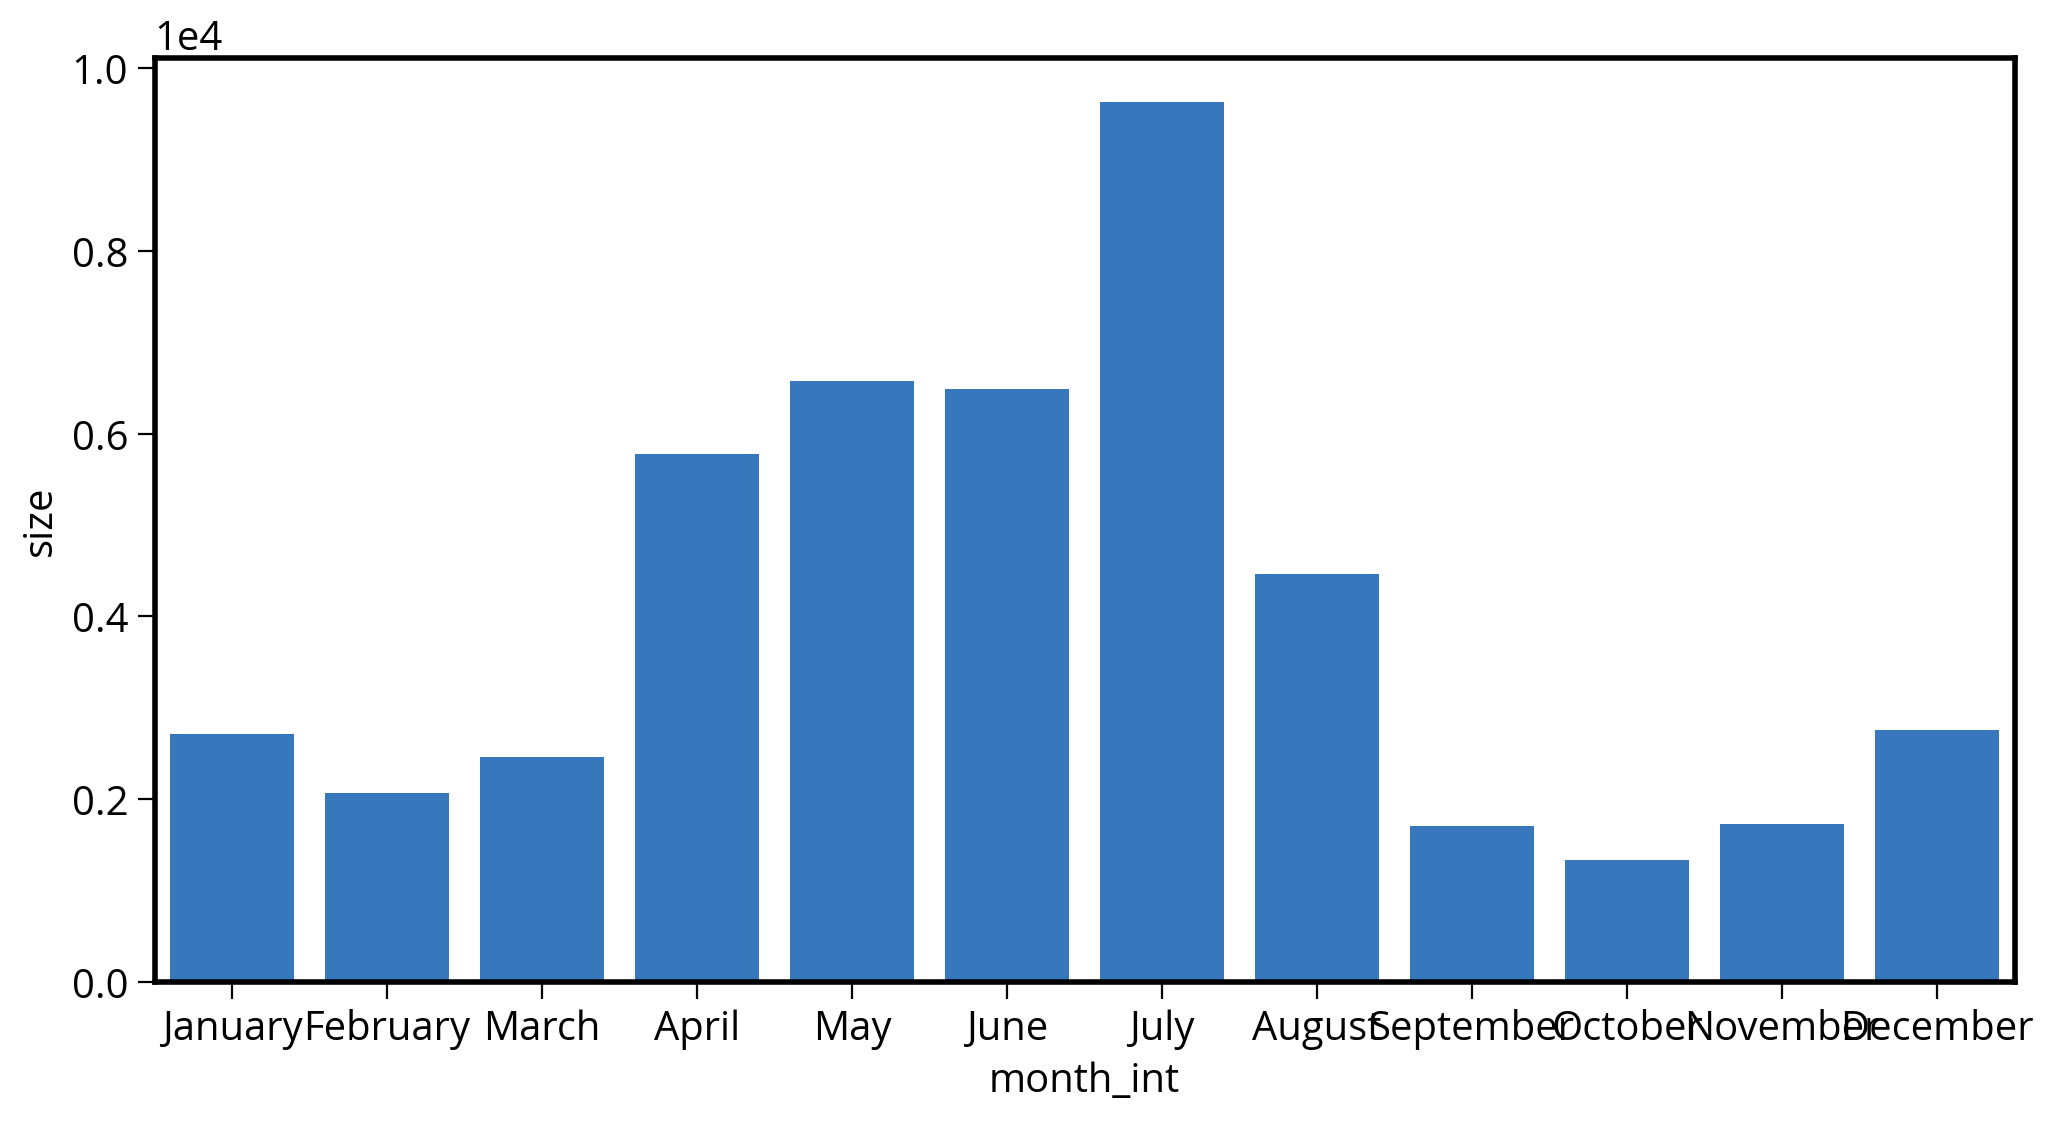

In [68]:
# Initialize figure/axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot!
sns.barplot(
    x="month_int",
    y="size",
    data=totals_by_month,
    color="#2176d2",
    ax=ax,
)


ax.set_xticklabels(totals_by_month["month"]);

### Example: Improving the aesthetics of matplotlib

The trend is clear in the previous chart, but can we do a better job with the aesthetics? Yes!

For reference, here is a common way to clean up charts in matplotlib:

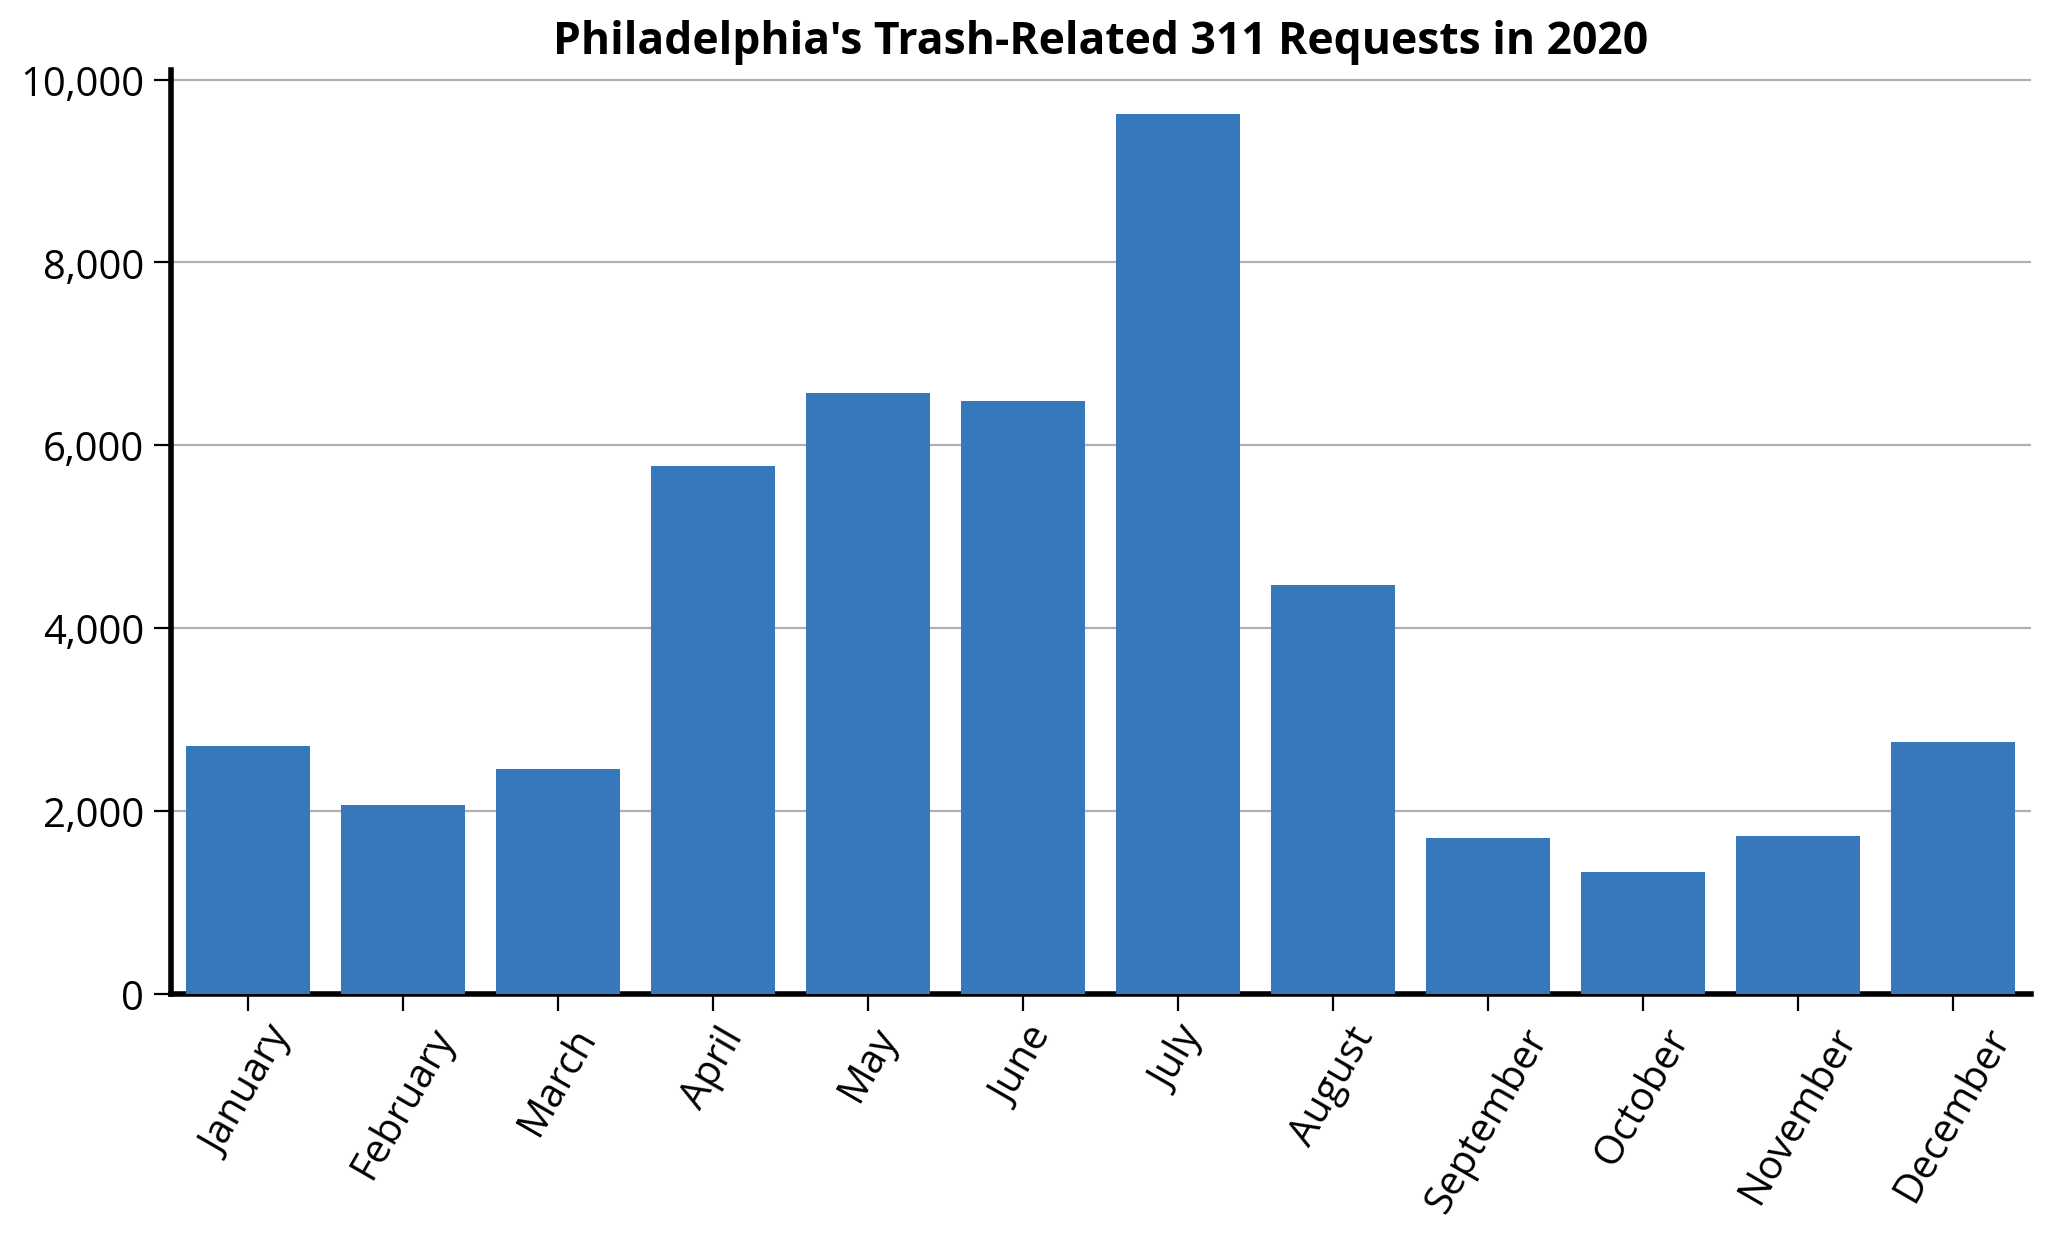

In [72]:
# Initialize figure/axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot!
sns.barplot(
    x="month",
    y="size",
    data=totals_by_month,
    color="#2176d2",
    ax=ax,
    order=[
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ],
    zorder=999,  # Make sure the bar charts are on top of the grid
)

# Remove x/y axis labels
ax.set_xlabel("")
ax.set_ylabel("")

# Set the yticks to go from 0 to 10,000 with 2,000 step
ax.set_yticks(np.arange(0, 1e4 + 1, 2e3))

# Format the ytick labels to use a comma and no decimal places
ax.set_yticklabels([f"{yval:,.0f}" for yval in ax.get_yticks()])

# Rotate the xticks
plt.setp(ax.get_xticklabels(), rotation=60)

# Add a grid backgrou d
ax.grid(True, axis="y")

# Remove the top and right axes lines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add a title
ax.set_title(
    "Philadelphia's Trash-Related 311 Requests in 2020", weight="bold", fontsize=16
);

## Part 2: Exploring geospatial trends in 311 requests

We'll examine the trends by neighborhoods across the city.

**Goal:** For each neighborhood, calculate the number of trash-related requests

### 1. Let's convert from lat/lng to Web Mercator

The original data has EPSG=4326. Our spatial operations won't work when the data is in latitude/longitude. We'll need to convert to a projected CRS — Web Mercator (EPSG=3857) will work just fine.

In [82]:
trash_requests = trash_requests.to_crs(epsg=3857)

### 2. Load Zillow neighborhood data

A GeoJSON holding Zillow definitions for Philadelphia neighborhoods is available in the `data/` directory. 

In [84]:
zillow = gpd.read_file("data/zillow_neighborhoods.geojson")

**Important:** Make sure it is in the same CRS as the request data!

In [85]:
zillow = zillow.to_crs(epsg=3857)

In [86]:
zillow.head()

ZillowName                                           geometry
0   Academy Gardens  POLYGON ((-8348795.677 4875297.327, -8348355.9...
1           Airport  POLYGON ((-8370923.380 4850336.405, -8370799.2...
2    Allegheny West  POLYGON ((-8367432.106 4866417.820, -8367436.0...
3           Andorra  POLYGON ((-8373967.120 4875663.024, -8374106.1...
4  Aston Woodbridge  POLYGON ((-8349918.770 4873746.906, -8349919.8...

A quick plot:

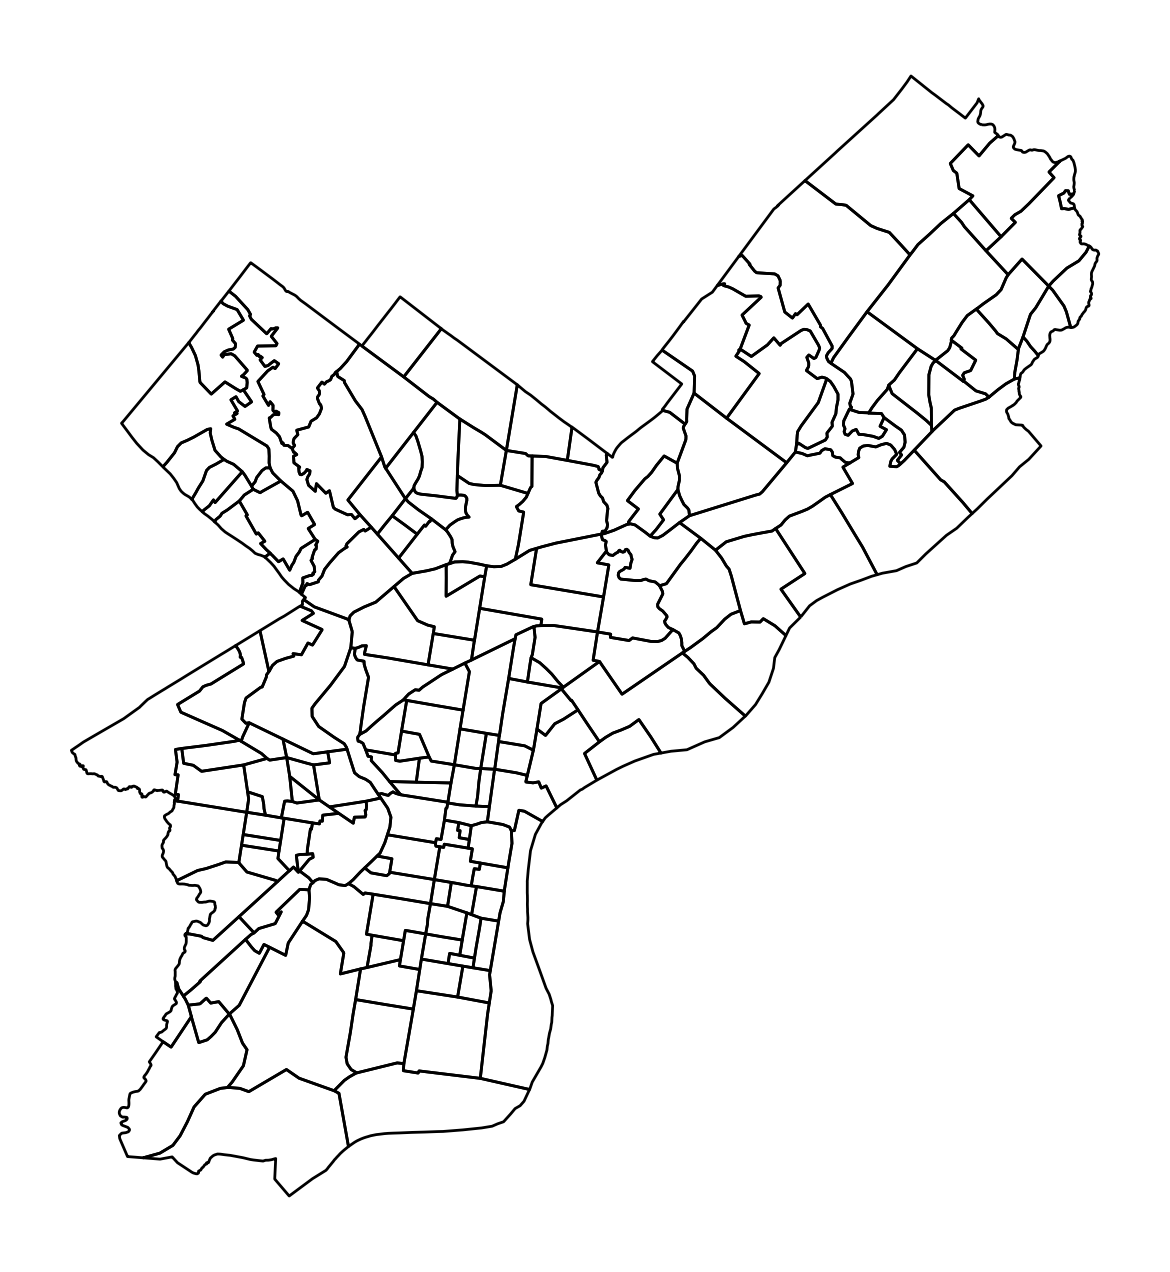

In [87]:
fig, ax = plt.subplots(figsize=(8, 8))

ax = zillow.plot(ax=ax, facecolor="none", edgecolor="black")

ax.set_axis_off()
ax.set_aspect("equal")

### 3. Do a spatial join between requests and neighborhoods

Use the `sjoin()` function to match point data (requests) to polygon data (neighborhoods) based on which neighborhood each request location is within.


In [90]:
requests_with_hood = gpd.sjoin(trash_requests, zillow, predicate="within", how="left")

In [91]:
requests_with_hood.head()

objectid  service_request_id  status status_notes  \
24    8180042            13269656  Closed          NaN   
25    8180043            13266979  Closed          NaN   
57    7744426            13066443  Closed          NaN   
58    7744427            13066540  Closed          NaN   
175   7801094            13089345  Closed          NaN   

                               service_name service_code  agency_responsible  \
24   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
25   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
57   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
58   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
175  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   

      service_notice   requested_datetime     updated_datetime  ... zipcode  \
24   2 Business Days  2020-04-02 19:22:24  2020-04-06 07:02:57  ...     NaN   
25   2 Business Days  2020-04-02 08:40:53  2020-04-06 07:02:58  ...     NaN   
57   2 Business Days  2020-01-02 19:17:55  2020-01-04 05:46:06  ...     NaN   
58   2 Business Days  2020-01-03 07:01:46  2020-01-04 05:46:07  ...     NaN   
175  2 Business Days  2020-01-15 13:22:14  2020-01-16 14:03:29  ...     NaN   

    media_url        lat        lon                       Coordinates  \
24        NaN  40.034389 -75.106518  POINT (-8360819.322 4870940.907)   
25        NaN  39.936164 -75.163497  POINT (-8367162.212 4856670.199)   
57        NaN  40.058737 -75.018345  POINT (-8351004.015 4874481.442)   
58        NaN  40.063658 -75.022347  POINT (-8351449.489 4875197.202)   
175       NaN  39.958186 -75.244732  POINT (-8376205.240 4859867.796)   

     requested_datetime_dt month_int    month  index_right       ZillowName  
24     2020-04-02 19:22:24         4    April         70.0         Lawndale  
25     2020-04-02 08:40:53         4    April        105.0  Passyunk Square  
57     2020-01-02 19:17:55         1  January        109.0  Pennypack Woods  
58     2020-01-03 07:01:46         1  January        107.0        Pennypack  
175    2020-01-15 13:22:14         1  January         21.0      Cobbs Creek  

[5 rows x 22 columns]

### 4. Group by neighborhood and calculate the size

In [100]:
totals = requests_with_hood.groupby("ZillowName", as_index=False).size()

type(totals)

pandas.core.frame.DataFrame

**Note:** we're once again using the `as_index=False` to ensure the result of the `.size()` function is a DataFrame rather than a Series with the `ZillowName` as its index

In [101]:
totals.head()

ZillowName  size
0   Academy Gardens    84
1    Allegheny West   330
2           Andorra    83
3  Aston Woodbridge   110
4   Bartram Village    35

### 5. Merge our geometries back in

Lastly, merge Zillow geometries (GeoDataFrame) with the total # of requests per neighborhood (DataFrame).

::: {.callout-warning title="Important"}

When merging a GeoDataFrame (spatial) and DataFrame (non-spatial), you should always call the `.merge()` function of the spatial data set to ensure that the merged data is a GeoDataFrame. 

:::

For example...

In [106]:
# Do GeoDataFrame.merge(DataFrame) here...
requests_by_hood = zillow.merge(totals, on="ZillowName")

In [107]:
requests_by_hood.head()

ZillowName                                           geometry  size
0   Academy Gardens  POLYGON ((-8348795.677 4875297.327, -8348355.9...    84
1    Allegheny West  POLYGON ((-8367432.106 4866417.820, -8367436.0...   330
2           Andorra  POLYGON ((-8373967.120 4875663.024, -8374106.1...    83
3  Aston Woodbridge  POLYGON ((-8349918.770 4873746.906, -8349919.8...   110
4   Bartram Village  POLYGON ((-8372041.314 4856283.292, -8372041.6...    35

### 6. Visualize as a choropleth map

Choropleth maps color polygon regions according to the values of a specific data attribute. *They are built-in to GeoDataFrame objects*.

Let's use the "size" column to plot the total number of requests per neighborhood:

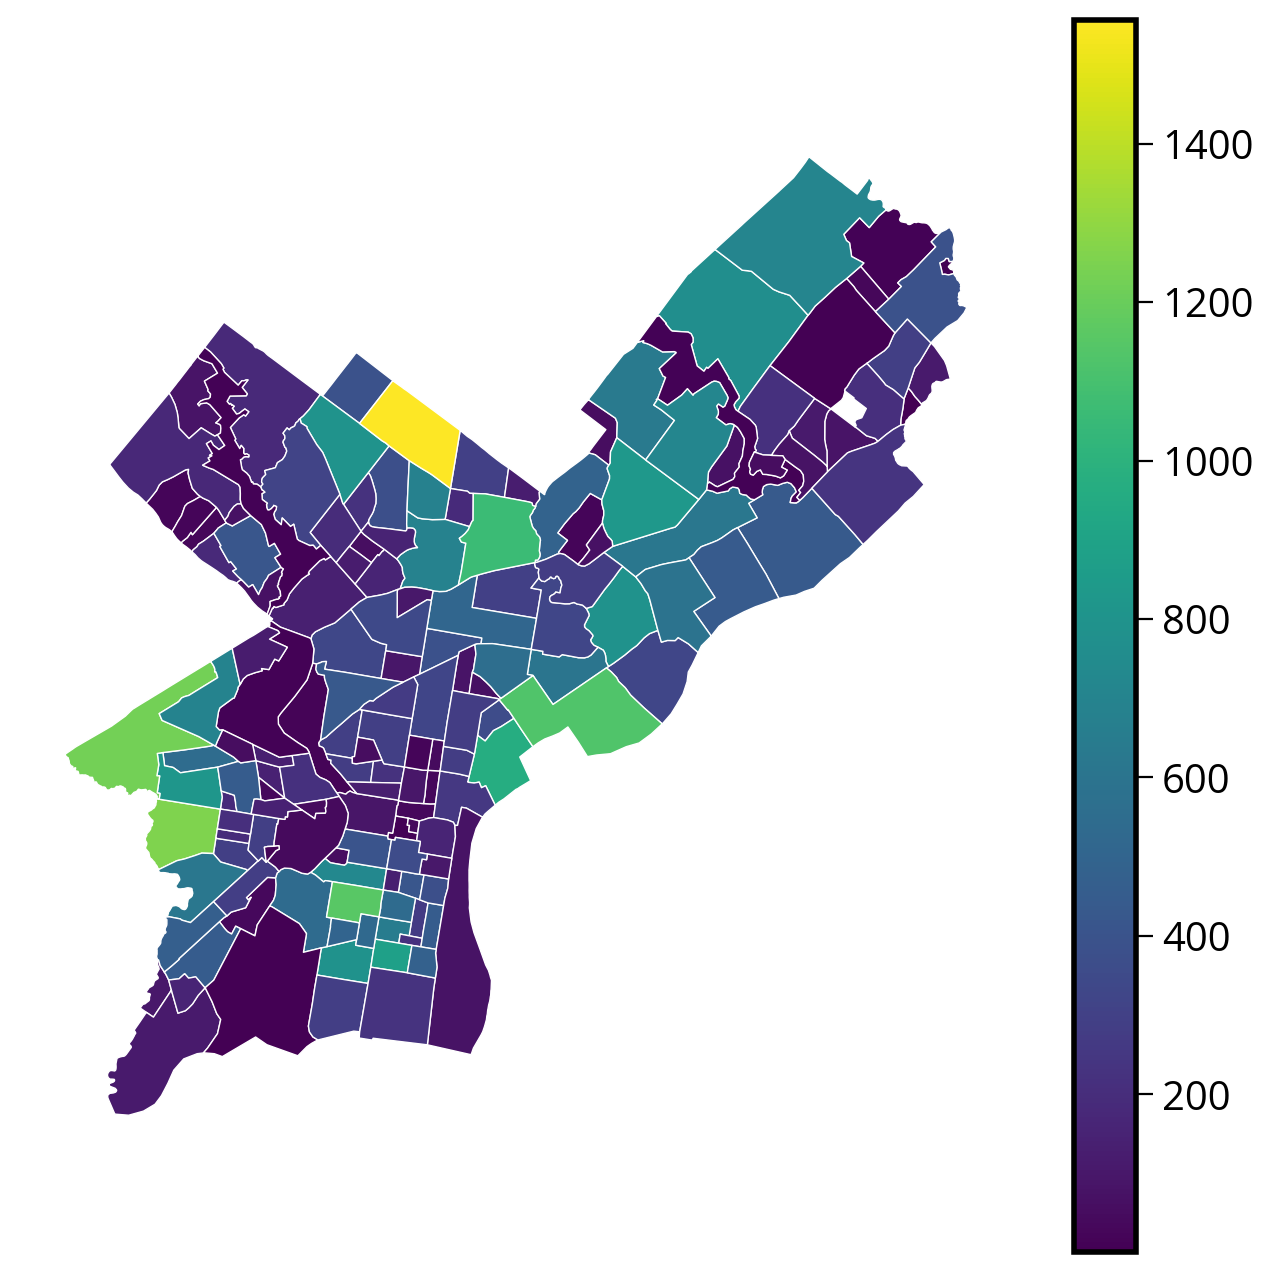

In [114]:
# Create the figure/axes
fig, ax = plt.subplots(figsize=(8, 8))

# Plot
requests_by_hood.plot(
    ax=ax,
    column="size",  # NEW: Specify the column to color polygons by
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    cmap="viridis",
)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

Can we make the aesthetics better?

Yes!

Some improvements:
- Make the colorbar line up with the axes. The default configuration will always overshoot the axes.
- Explicitly set the limits of the x-axis and y-axis to zoom in and center the map

In [115]:
# Needed to line up the colorbar properly
from mpl_toolkits.axes_grid1 import make_axes_locatable

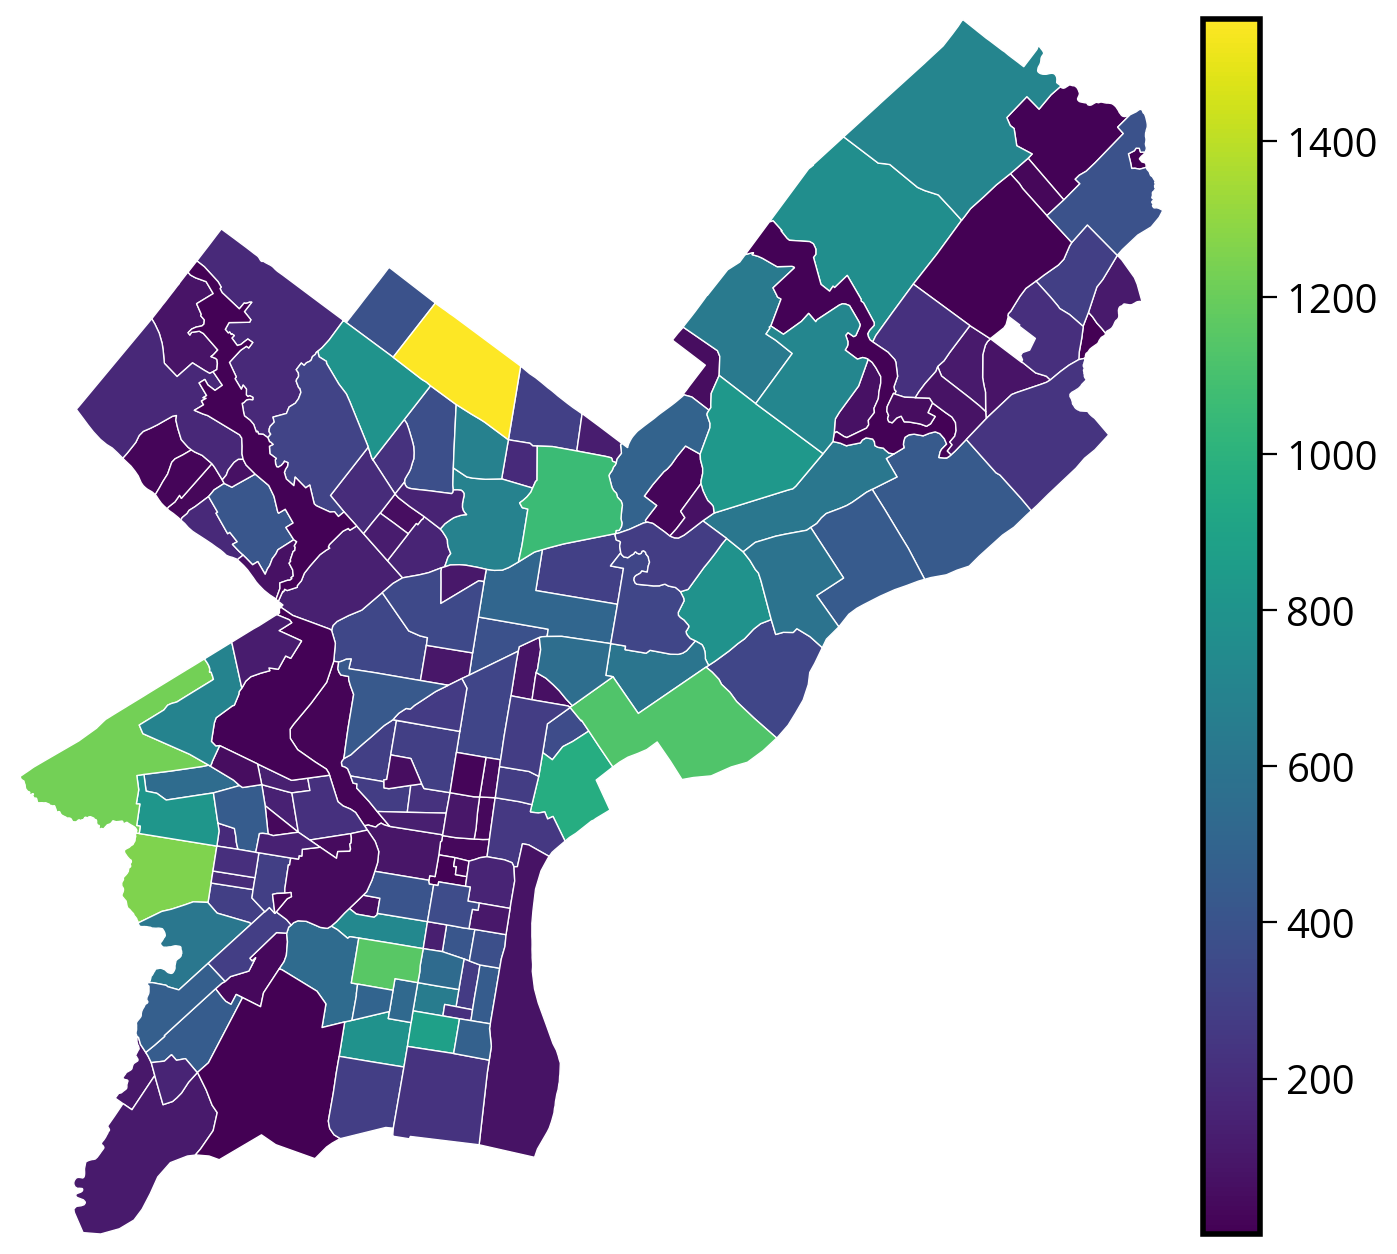

In [116]:
# Create the figure
fig, ax = plt.subplots(figsize=(8, 8))

# NEW: Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
requests_by_hood.plot(
    ax=ax,
    cax=cax,  # NEW
    column="size",
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    cmap="viridis",
)

# NEW: Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = requests_by_hood.total_bounds

# NEW: Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

*These improvements are optional, but they definitely make for nicer plots!*

**Question:** Can we classify the data into bins? 

Yes, built-in to the `plot()` function!

#### Classification schemes

Many different schemes, but here are some of the most common ones:

1. "Quantiles" : assigns the same number of data points per bin
1. "EqualInterval" : divides the *range of the data* into equally sized bins
1. "FisherJenks": [scheme](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization) that tries to minimize the variance within each bin and maximize the variances between different bins.

Quantiles Scheme

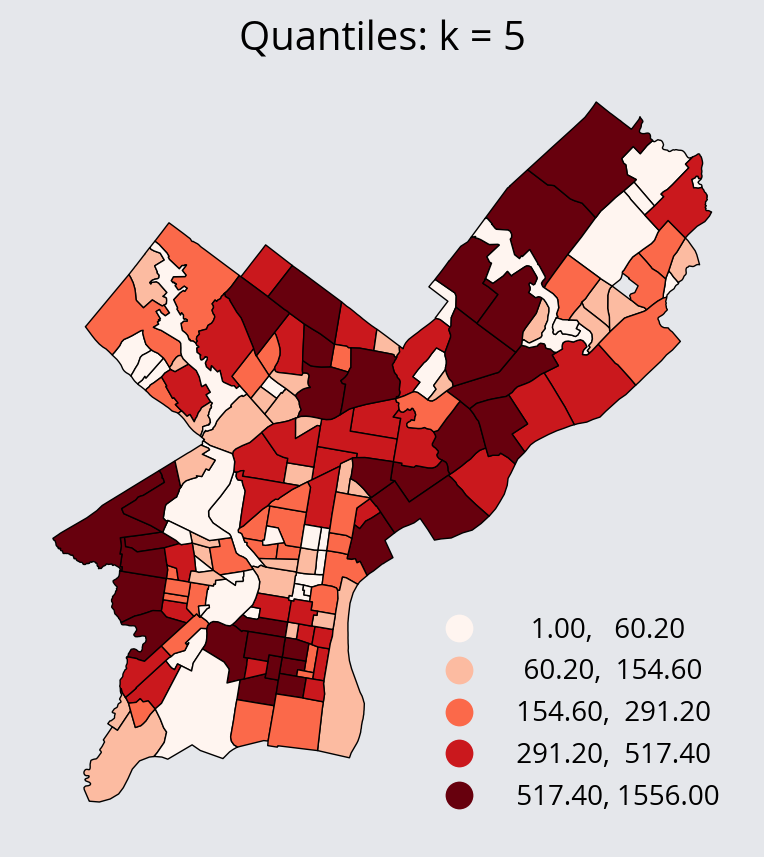

In [137]:
# Initialize figure and axes
fig, ax = plt.subplots(figsize=(8, 5), facecolor="#e5e7eb")

# Plot
requests_by_hood.plot(
    ax=ax,
    column="size",
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    legend_kwds=dict(loc="lower right", fontsize=10),
    cmap="Reds",
    scheme="Quantiles",
    k=5,
)

# Format
ax.set_title("Quantiles: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

Equal Interval Scheme:

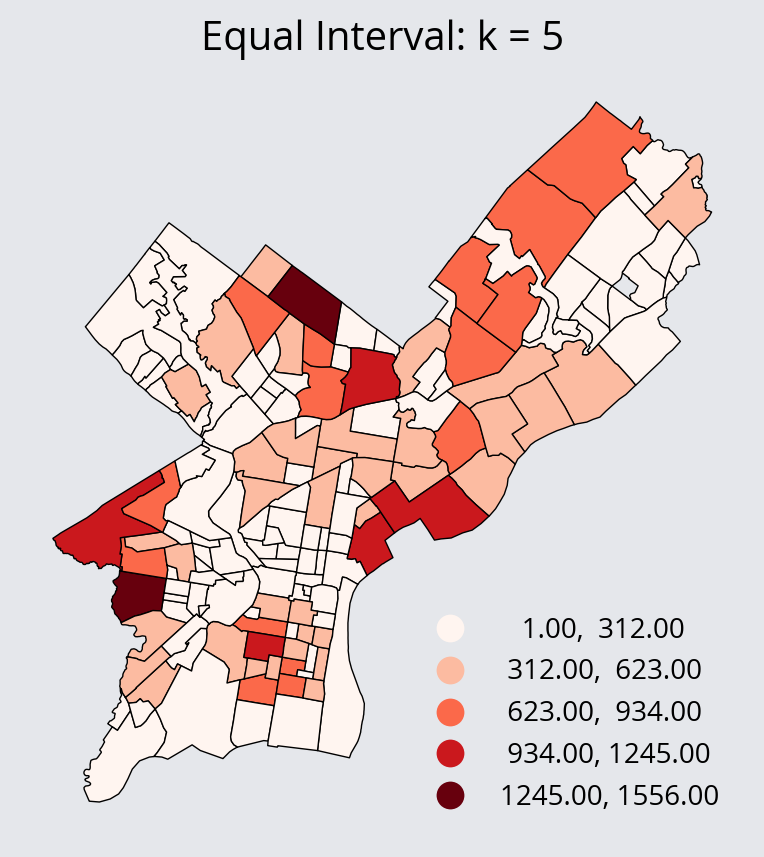

In [135]:
# Initialize figure and axes
fig, ax = plt.subplots(figsize=(8, 5), facecolor="#e5e7eb")

# Plot
requests_by_hood.plot(
    ax=ax,
    column="size",
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    legend_kwds=dict(loc="lower right", fontsize=10),
    cmap="Reds",
    scheme="EqualInterval",
    k=5,
)

# Format
ax.set_title("Equal Interval: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

Fisher Jenks Scheme

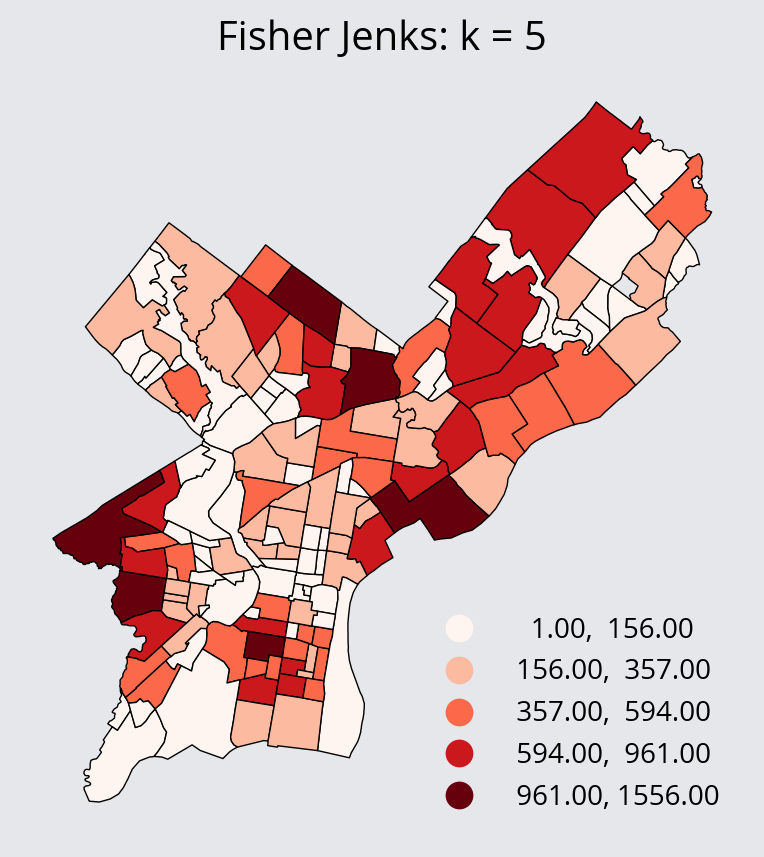

In [140]:
# Initialize figure and axes
fig, ax = plt.subplots(figsize=(8, 5), facecolor="#e5e7eb")

# Plot
requests_by_hood.plot(
    ax=ax,
    column="size",
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    legend_kwds=dict(loc="lower right", fontsize=10),
    cmap="Reds",
    scheme="FisherJenks",
)

# Format
ax.set_title("Fisher Jenks: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

::: {.callout-tip}

Geopandas relies on an external package called `mapclassify` for the classification schemes. 
The documentation can be found here: https://pysal.org/mapclassify/api.html

It contains the full list of schemes and the function definitions for each.
:::

### 7. Neighborhood sizes still make it hard to compare raw counts

Better to normalize by area: **use the .area attribute of the geometry series**

In [141]:
requests_by_hood["N_per_area"] = (
    requests_by_hood["size"] / (requests_by_hood.geometry.area) * 1e4
)

Now plot the normalized totals:

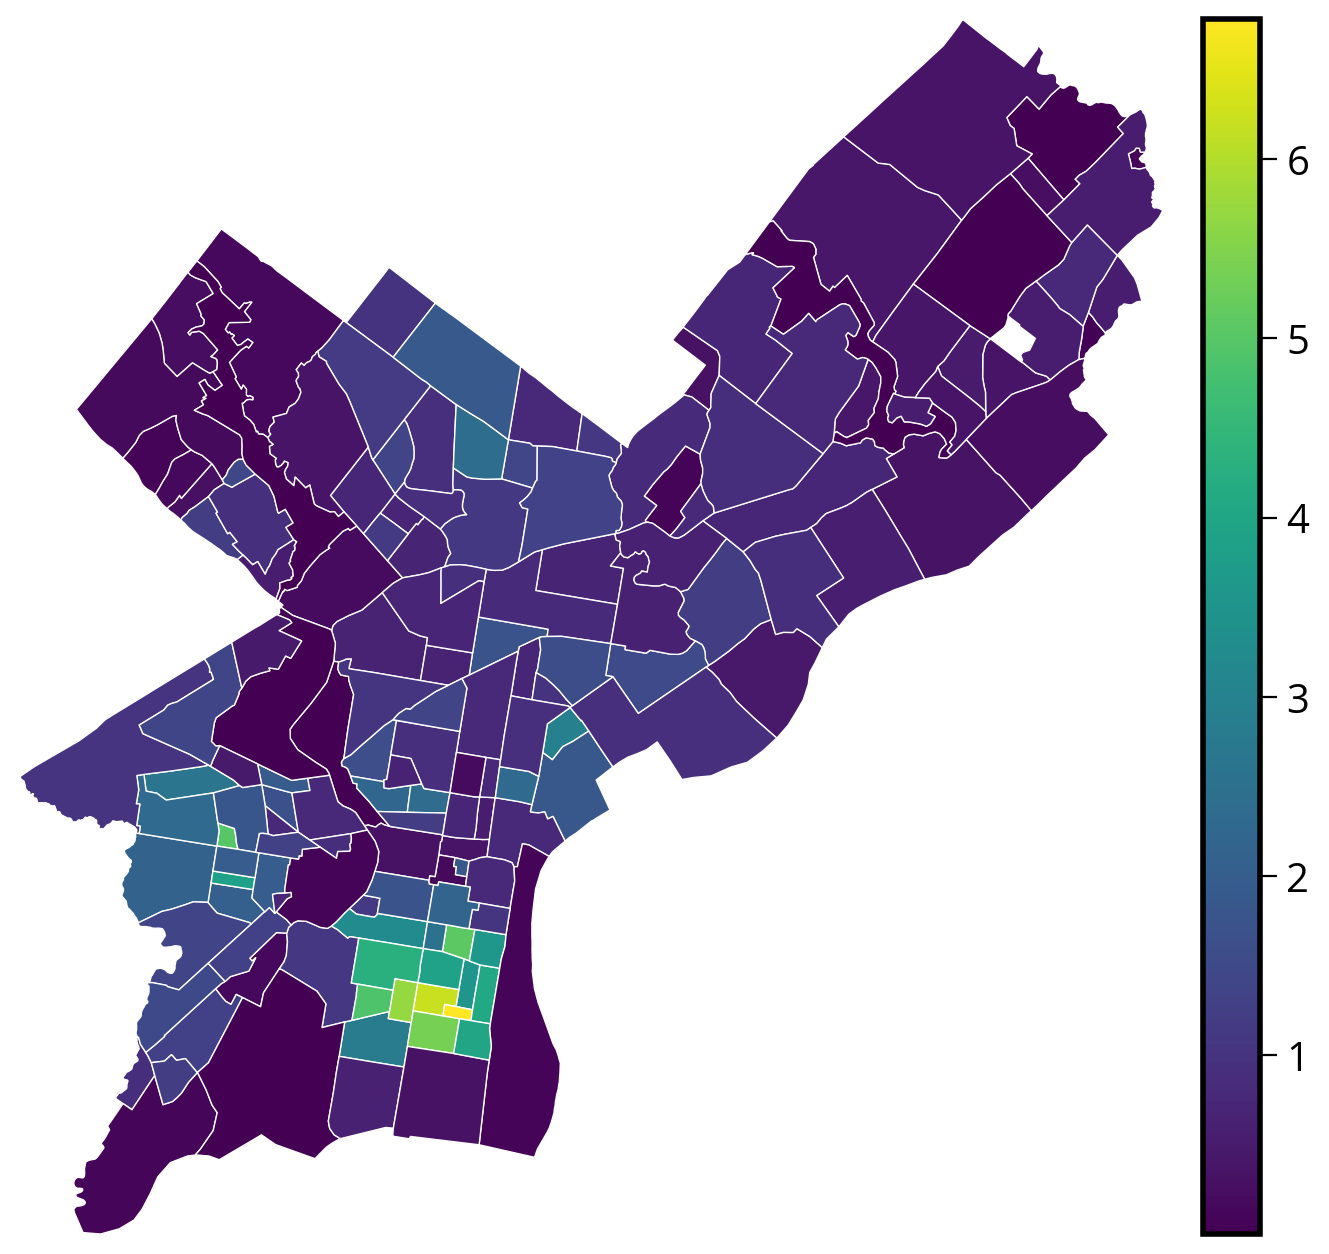

In [143]:
# Create the figure
fig, ax = plt.subplots(figsize=(8, 8))

# Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
requests_by_hood.plot(
    ax=ax,
    cax=cax,
    column="N_per_area",  # NEW: Use the normalized column
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    cmap="viridis",
)

# Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = requests_by_hood.total_bounds

# Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

#### Even smarter

Since households are driving the 311 requests, it would be even better to normalize by the number of properties in a given neighborhood rather than neighborhood area

### 8. More advanced: hex bins with matplotlib

Hexagonal bins aggregate quantities over small spatial regions.

**Use matplotlib's `hexbin()` function**

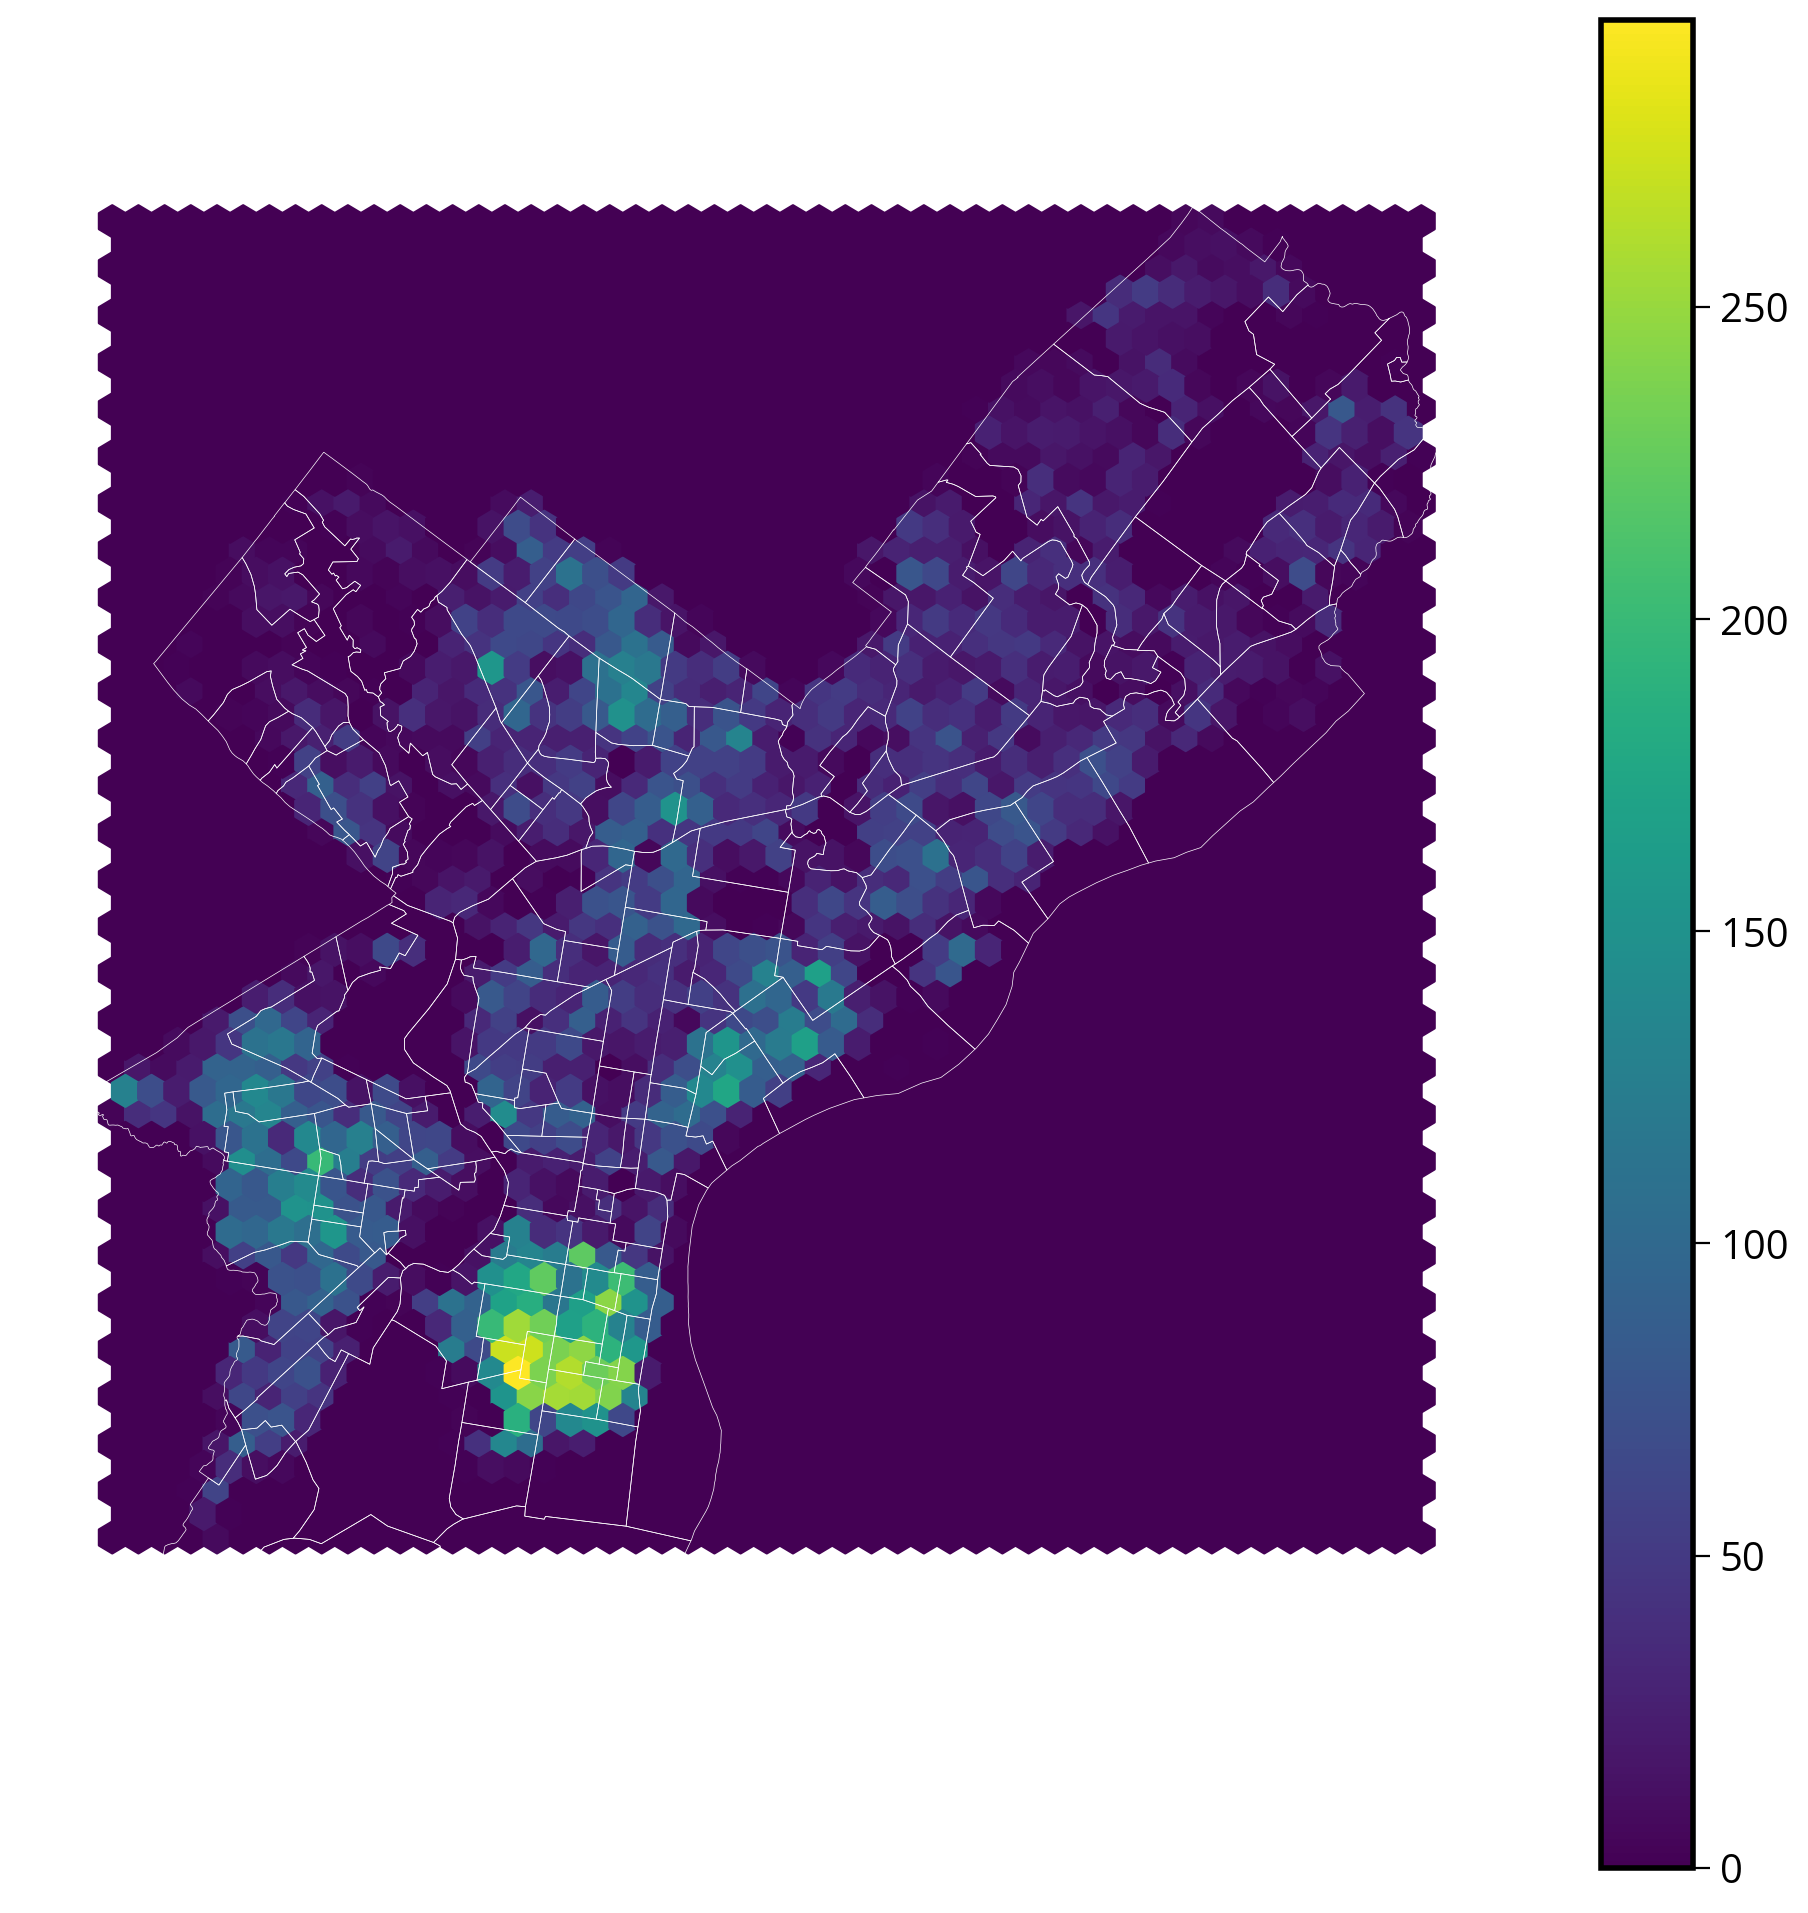

In [145]:
# Create the axes
fig, ax = plt.subplots(figsize=(12, 12))


# Extract out the x/y coordindates of the Point objects
xcoords = trash_requests.geometry.x
ycoords = trash_requests.geometry.y

# Plot a hexbin chart
# NOTE: We are passing the full set of coordinates to matplotlib — we haven't done any aggregations
hex_vals = ax.hexbin(xcoords, ycoords, gridsize=50)

# Add the zillow geometry boundaries
zillow.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=0.25)

# Add a colorbar and format
fig.colorbar(hex_vals, ax=ax)
ax.set_axis_off()
ax.set_aspect("equal")

### 9. Add interactivity with altair

Altair has full support for `GeoDataFrames`, making interactive choropleths very easy to make!

In [152]:
# IMPORTANT: Altair needs the GeoDataFrame to be in EPSG:4326
requests_by_hood_4326 = requests_by_hood.to_crs(epsg=4326)

# plot map, where variables ares nested within `properties`,
(
    alt.Chart(requests_by_hood_4326)
    .mark_geoshape(stroke="white")
    .encode(
        tooltip=["N_per_area:Q", "ZillowName:N", "size:Q"],
        color=alt.Color("N_per_area:Q", scale=alt.Scale(scheme="viridis")),
    )
    .properties(width=500, height=400)
)

alt.Chart(...)

**Challenge for later:** use altair's *repeated charts* to show several choropleths for different 311 request types at once.

A similar example (using a different dataset) is available in the [altair gallery](https://altair-viz.github.io/gallery/choropleth_repeat.html).

## Exercise: property assessments in Philadelphia

**Goals**: 
Visualize the property assessment values by neighborhood in Philadelphia, using a
1. static choropleth map
1. hex bin map
1. interactive choropleth with altair


### The dataset

- Property assessment data from [OpenDataPhilly](https://www.opendataphilly.org/dataset/opa-property-assessments)
- Available in the `data/` folder
- Residential properties only — over 460,000 properties 

### Step 1: Load the assessment data

In [153]:
data = pd.read_csv("./data/opa_residential.csv")
data.head()

parcel_number        lat        lng   location  market_value  \
0       71361800  39.991575 -75.128994  2726 A ST       62200.0   
1       71362100  39.991702 -75.128978  2732 A ST       25200.0   
2       71362200  39.991744 -75.128971  2734 A ST       62200.0   
3       71362600  39.991994 -75.128895  2742 A ST       15500.0   
4       71363800  39.992592 -75.128743  2814 A ST       31300.0   

   building_value  land_value  total_land_area  total_livable_area  
0         44473.0     17727.0          1109.69              1638.0  
1         18018.0      7182.0          1109.69              1638.0  
2         44473.0     17727.0          1109.69              1638.0  
3         11083.0      4417.0          1109.69              1638.0  
4         22400.0      8900.0           643.50               890.0

We'll focus on the `market_value` column for this analysis

### Step 2: Convert to a GeoDataFrame

Remember to set the EPSG of the input data — this data is in the typical lat/lng coordinates (EPSG=4326)

In [155]:
data = data.dropna(subset=["lat", "lng"])

In [156]:
data["Coordinates"] = gpd.points_from_xy(data["lng"], data["lat"])

In [157]:
gdata = gpd.GeoDataFrame(data, geometry="Coordinates", crs="EPSG:4326")

In [158]:
gdata.head()

parcel_number        lat        lng   location  market_value  \
0       71361800  39.991575 -75.128994  2726 A ST       62200.0   
1       71362100  39.991702 -75.128978  2732 A ST       25200.0   
2       71362200  39.991744 -75.128971  2734 A ST       62200.0   
3       71362600  39.991994 -75.128895  2742 A ST       15500.0   
4       71363800  39.992592 -75.128743  2814 A ST       31300.0   

   building_value  land_value  total_land_area  total_livable_area  \
0         44473.0     17727.0          1109.69              1638.0   
1         18018.0      7182.0          1109.69              1638.0   
2         44473.0     17727.0          1109.69              1638.0   
3         11083.0      4417.0          1109.69              1638.0   
4         22400.0      8900.0           643.50               890.0   

                  Coordinates  
0  POINT (-75.12899 39.99158)  
1  POINT (-75.12898 39.99170)  
2  POINT (-75.12897 39.99174)  
3  POINT (-75.12889 39.99199)  
4  POINT (-75.12874 39.99259)

In [160]:
len(gdata)

461453

### Step 3: Do a spatial join with Zillow neighbohoods

Use the `sjoin()` function. 

Make sure you CRS's match before doing the sjoin!

In [161]:
zillow.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [162]:
gdata = gdata.to_crs(epsg=3857)

# could also do:
# gdata = gdata.to_crs(zillow.crs)

In [163]:
gdata = gpd.sjoin(gdata, zillow, predicate="within", how="left")

In [164]:
gdata.head()

parcel_number        lat        lng   location  market_value  \
0       71361800  39.991575 -75.128994  2726 A ST       62200.0   
1       71362100  39.991702 -75.128978  2732 A ST       25200.0   
2       71362200  39.991744 -75.128971  2734 A ST       62200.0   
3       71362600  39.991994 -75.128895  2742 A ST       15500.0   
4       71363800  39.992592 -75.128743  2814 A ST       31300.0   

   building_value  land_value  total_land_area  total_livable_area  \
0         44473.0     17727.0          1109.69              1638.0   
1         18018.0      7182.0          1109.69              1638.0   
2         44473.0     17727.0          1109.69              1638.0   
3         11083.0      4417.0          1109.69              1638.0   
4         22400.0      8900.0           643.50               890.0   

                        Coordinates  index_right ZillowName  
0  POINT (-8363321.403 4864718.063)         79.0    McGuire  
1  POINT (-8363319.628 4864736.535)         79.0    McGuire  
2  POINT (-8363318.762 4864742.658)         79.0    McGuire  
3  POINT (-8363310.304 4864778.984)         79.0    McGuire  
4  POINT (-8363293.378 4864865.767)         79.0    McGuire

### Step 4: Make a choropleth of the median market value by neighborhood

::: {.callout-tip title="Hints"}
- You will need to group by Zillow neighborhood
- Calculate the median market value per neighborhood
- Join with the Zillow neighborhood GeoDataFrame
:::

In [174]:
median_values = gdata.groupby("ZillowName", as_index=False)["market_value"].median()

In [175]:
median_values.head()

ZillowName  market_value
0   Academy Gardens      185950.0
1    Allegheny West       34750.0
2           Andorra      251900.0
3  Aston Woodbridge      183800.0
4   Bartram Village       48300.0

In [176]:
# Merge in the median values ---> geopandas .merge pandas
median_values_by_hood = zillow.merge(median_values, on="ZillowName")

# Normalize
median_values_by_hood["market_value"] /= 1e3  # in thousands

In [177]:
median_values_by_hood.head()

ZillowName                                           geometry  \
0   Academy Gardens  POLYGON ((-8348795.677 4875297.327, -8348355.9...   
1    Allegheny West  POLYGON ((-8367432.106 4866417.820, -8367436.0...   
2           Andorra  POLYGON ((-8373967.120 4875663.024, -8374106.1...   
3  Aston Woodbridge  POLYGON ((-8349918.770 4873746.906, -8349919.8...   
4   Bartram Village  POLYGON ((-8372041.314 4856283.292, -8372041.6...   

   market_value  
0        185.95  
1         34.75  
2        251.90  
3        183.80  
4         48.30

/var/folders/49/ntrr94q12xd4rq8hqdnx96gm0000gn/T/ipykernel_52961/2868065500.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels([f"${val:.0f}k" for val in cax.get_yticks()]);


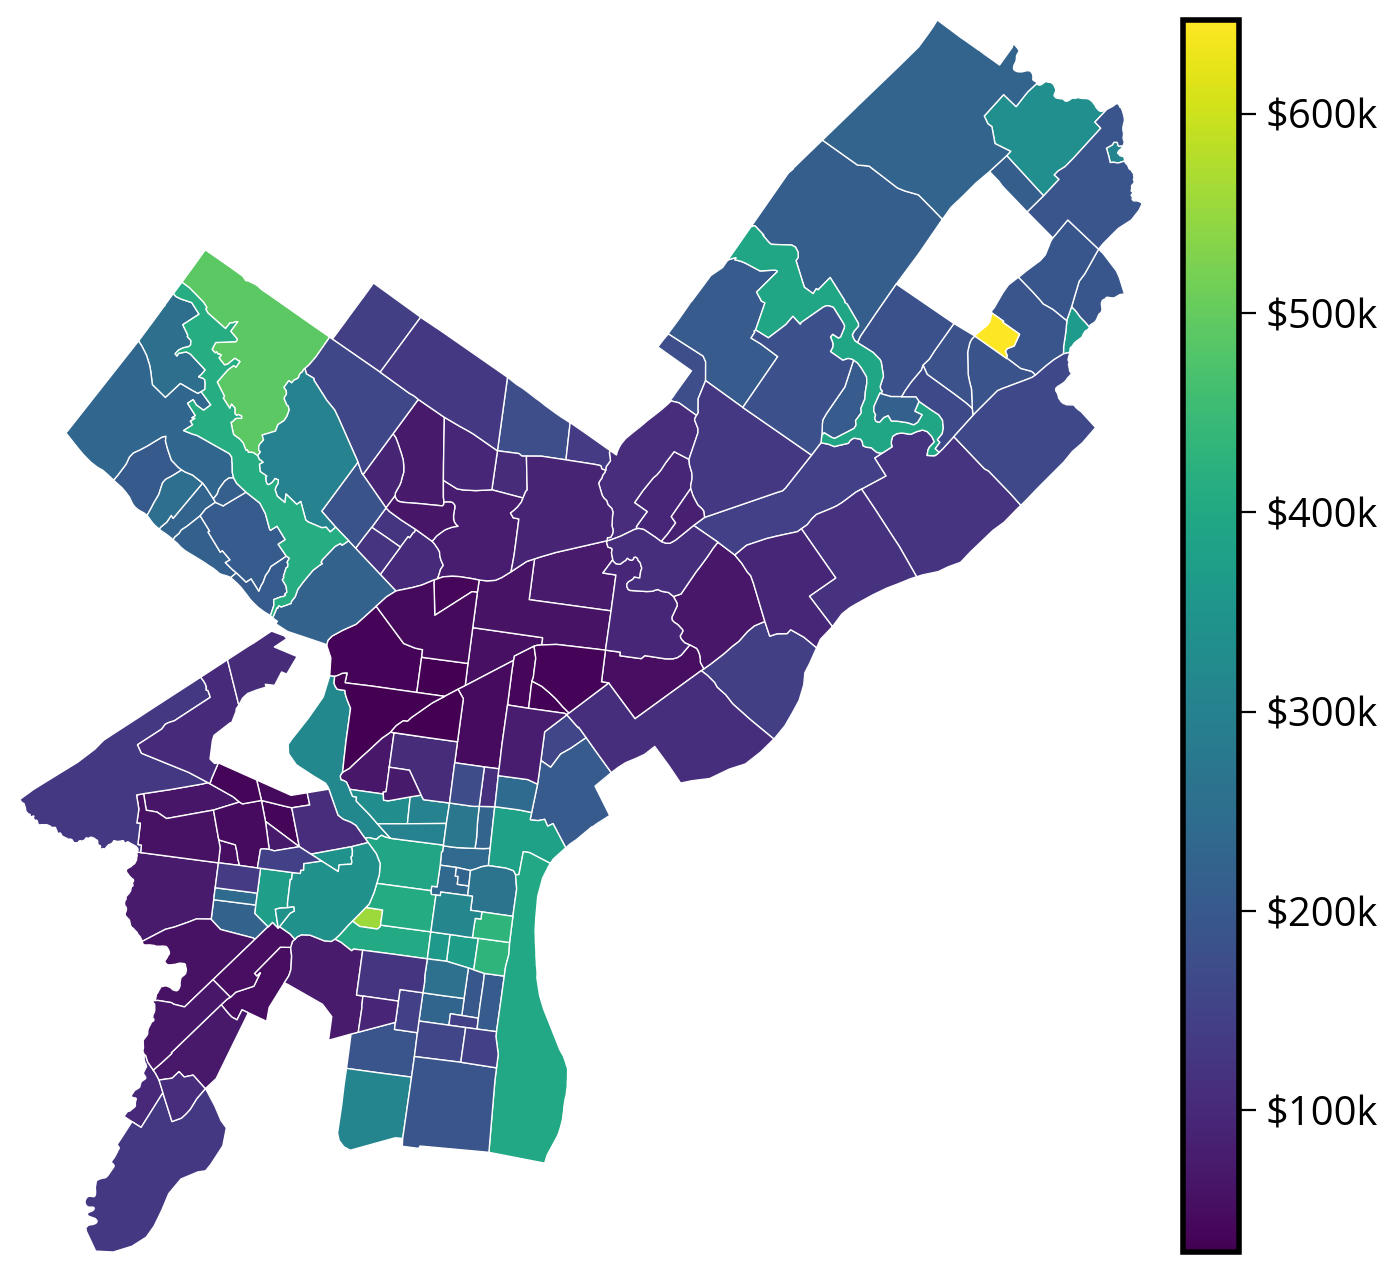

In [178]:
# Create the figure
fig, ax = plt.subplots(figsize=(8, 8))

# Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
# NOTE: I am using PA state plane (2272)
median_values_by_hood_2272 = median_values_by_hood.to_crs(epsg=2272)
median_values_by_hood_2272.plot(
    ax=ax, cax=cax, column="market_value", edgecolor="white", linewidth=0.5, legend=True
)

# Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = median_values_by_hood_2272.total_bounds

# Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

# Format cax labels
cax.set_yticklabels([f"${val:.0f}k" for val in cax.get_yticks()]);

### Step 5: Make a hex bin map of median assessments

::: {.callout-tip title="Hints"}

- You will need to use the `C` and `reduce_C_function` of the `hexbin()` function
- Run `plt.hexbin?` for more help
- Try testing the impact of setting `bins='log'` on the resulting map

:::

**Note:** you should pass in the raw point data rather than any aggregated data to the `hexbin()` function

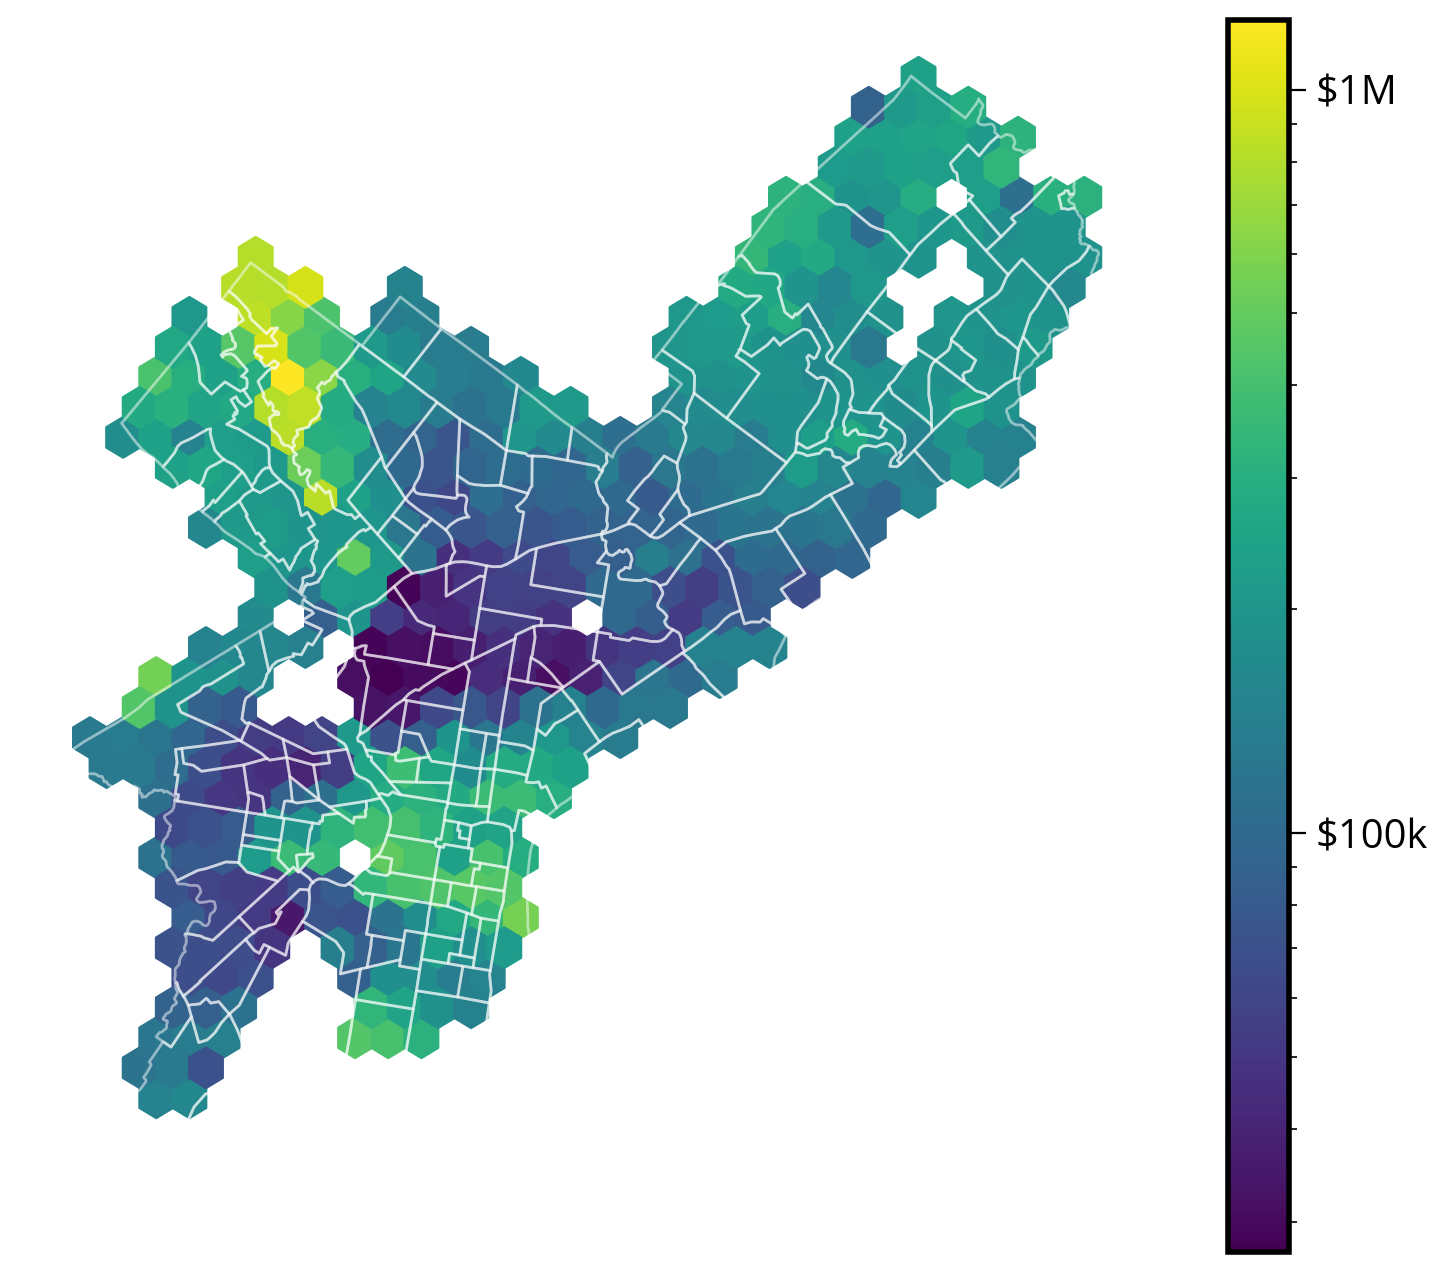

In [180]:
# Create the axes
fig, ax = plt.subplots(figsize=(10, 8))

# Use the .x and .y attributes to get coordinates
xcoords = gdata.geometry.x
ycoords = gdata.geometry.y

# NOTE: we are passing in the raw point values here!
# Matplotlib is doing the binning and aggregation work for us!
hex_vals = ax.hexbin(
    xcoords,
    ycoords,
    C=gdata.market_value / 1e3,  # Values to aggregate!
    reduce_C_function=np.median,  # Use the median function to do the aggregation in each bin
    bins="log",  # Use log scale for color
    gridsize=30,
)

# Add the zillow geometry boundaries
zillow.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=1, alpha=0.5)

# Add a colorbar and format
cbar = fig.colorbar(hex_vals, ax=ax)
ax.set_axis_off()
ax.set_aspect("equal")

# Format cbar labels
cbar.set_ticks([100, 1000])
cbar.set_ticklabels(["$100k", "$1M"]);

### Step 6: Use altair to make an interactive choropleth

In [181]:
# Convert median values to EPSG=4326
median_values_by_hood_4326 = median_values_by_hood.to_crs(epsg=4326)

# Plot the map
chart = (
    alt.Chart(median_values_by_hood_4326)
    .mark_geoshape(stroke="white")
    .encode(
        tooltip=["market_value:Q", "ZillowName:N"],
        color=alt.Color("market_value:Q", scale=alt.Scale(scheme="viridis")),
    )
    .properties(width=500, height=400)
)

chart

alt.Chart(...)

## That's it!

- More interactive viz libraries and raster datasets next week!
- See you next Monday!